In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

from hmog import HmogHelper
from tqdm import tqdm

dataset_path = 'preprocessed_data/'

In [2]:
WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

In [3]:
class SimpleNeuralNet(nn.Module):
    def __init__(self) -> None:
        super(SimpleNeuralNet, self).__init__()

        input_shape = 64

        self.fc1 = nn.Linear(input_shape, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=16, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.out(x)

        return x

In [5]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        # self.dataset = np.load(file_path)
        self.X = X
        self.y = y
        self.transform = transform
        
        # self.X = self.dataset[:, 1:-1]
        # self.y = self.dataset[:, -1]
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        # if self.transform is not None:
        #     curr_item_x = self.transform(self.X[idx])
        #     curr_item_y = self.transform(self.y[idx])
        #     
        #     return curr_item_x, curr_item_y
    
        return self.X[idx], self.y[idx]

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

whole_dataset = np.load(os.path.join(dataset_path, 'hmog_vectors_with_labels.npy'))
whole_dataset = whole_dataset.astype(np.float32)

scaler = StandardScaler()

X, y = whole_dataset[:, 1:-1], whole_dataset[:, -1]
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MyDataset(X_train, y_train, transform=None)
val_dataset = MyDataset(X_val, y_val, transform=None)
test_dataset = MyDataset(X_test, y_test, transform=None)

print(len(train_dataset), len(val_dataset), len(test_dataset))

333997 83500 104375


In [13]:
def train_one_epoch(model, dataloader, loss_fn, device):
    running_loss = 0.
    last_loss = 0.
    
    model.train()

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(inputs).reshape(-1)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [14]:
model = SimpleNeuralNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [16]:
EPOCHS = 50

vlosses = []
tlosses = []

In [17]:
for epoch in tqdm(range(EPOCHS)):
    avg_loss = train_one_epoch(model, train_dataloader, criterion, device)
    tlosses.append(avg_loss)

    running_vloss = 0.0

    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device, dtype=torch.float32), vlabels.to(device, dtype=torch.float32)
            
            voutputs = model(vinputs).reshape(-1)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    vlosses.append(avg_vloss)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

  0%|          | 0/50 [00:00<?, ?it/s]

  batch 1000 loss: 0.35093071483075616
  batch 2000 loss: 0.2621492743045092
  batch 3000 loss: 0.23309322221577167
  batch 4000 loss: 0.23138762754946948
  batch 5000 loss: 0.22354943090304732


  2%|▏         | 1/50 [00:02<02:04,  2.53s/it]

LOSS train 0.22354943090304732 valid 0.21721602976322174
  batch 1000 loss: 0.21007226038724183
  batch 2000 loss: 0.2132428049221635
  batch 3000 loss: 0.21252148574590682
  batch 4000 loss: 0.20589394792169333
  batch 5000 loss: 0.20649509567022323


  4%|▍         | 2/50 [00:05<02:00,  2.52s/it]

LOSS train 0.20649509567022323 valid 0.2032816857099533
  batch 1000 loss: 0.2075821570791304
  batch 2000 loss: 0.19854251343384385
  batch 3000 loss: 0.20232576383277773
  batch 4000 loss: 0.20556514340639115
  batch 5000 loss: 0.1994351653084159


  6%|▌         | 3/50 [00:07<01:57,  2.51s/it]

LOSS train 0.1994351653084159 valid 0.20044425129890442
  batch 1000 loss: 0.19326941744238138
  batch 2000 loss: 0.19449310257285835
  batch 3000 loss: 0.1980221923664212
  batch 4000 loss: 0.19671694488450886
  batch 5000 loss: 0.1954161761254072


  8%|▊         | 4/50 [00:10<01:55,  2.50s/it]

LOSS train 0.1954161761254072 valid 0.19576138257980347
  batch 1000 loss: 0.19243293141946197
  batch 2000 loss: 0.19050916606932877
  batch 3000 loss: 0.19334993246570228
  batch 4000 loss: 0.19192960022762418
  batch 5000 loss: 0.19026510667428373


 10%|█         | 5/50 [00:12<01:51,  2.48s/it]

LOSS train 0.19026510667428373 valid 0.19147072732448578
  batch 1000 loss: 0.18902918572351338
  batch 2000 loss: 0.18809711388126016
  batch 3000 loss: 0.19287570720911026
  batch 4000 loss: 0.19159074508026241
  batch 5000 loss: 0.18928196819499135


 12%|█▏        | 6/50 [00:14<01:48,  2.46s/it]

LOSS train 0.18928196819499135 valid 0.1869448572397232
  batch 1000 loss: 0.1852723897509277
  batch 2000 loss: 0.1874197268858552
  batch 3000 loss: 0.18843851149827243
  batch 4000 loss: 0.18478238799795507
  batch 5000 loss: 0.18607707979902624


 14%|█▍        | 7/50 [00:17<01:46,  2.47s/it]

LOSS train 0.18607707979902624 valid 0.18478168547153473
  batch 1000 loss: 0.18197128646820784
  batch 2000 loss: 0.18563985151425005
  batch 3000 loss: 0.1823291972465813
  batch 4000 loss: 0.18498887746781112
  batch 5000 loss: 0.1869858956411481


 16%|█▌        | 8/50 [00:19<01:43,  2.47s/it]

LOSS train 0.1869858956411481 valid 0.1835128515958786
  batch 1000 loss: 0.18097757988795637
  batch 2000 loss: 0.18282843399420382
  batch 3000 loss: 0.18160505099222063
  batch 4000 loss: 0.18116054717823862
  batch 5000 loss: 0.18218559558689595


 18%|█▊        | 9/50 [00:22<01:41,  2.46s/it]

LOSS train 0.18218559558689595 valid 0.18754781782627106
  batch 1000 loss: 0.18064640610292554
  batch 2000 loss: 0.18093996304646134
  batch 3000 loss: 0.17991032534092666
  batch 4000 loss: 0.1849480132199824
  batch 5000 loss: 0.18264903097972274


 20%|██        | 10/50 [00:24<01:39,  2.48s/it]

LOSS train 0.18264903097972274 valid 0.18255339562892914
  batch 1000 loss: 0.18216565779596566
  batch 2000 loss: 0.18015992538630962
  batch 3000 loss: 0.18326117952913046
  batch 4000 loss: 0.17850268529355526
  batch 5000 loss: 0.18356476400792598


 22%|██▏       | 11/50 [00:27<01:36,  2.47s/it]

LOSS train 0.18356476400792598 valid 0.18171384930610657
  batch 1000 loss: 0.17858430431038141
  batch 2000 loss: 0.1808349059149623
  batch 3000 loss: 0.17970049782842398
  batch 4000 loss: 0.18017843278497458
  batch 5000 loss: 0.17978287163376808


 24%|██▍       | 12/50 [00:29<01:33,  2.46s/it]

LOSS train 0.17978287163376808 valid 0.18134135007858276
  batch 1000 loss: 0.17716134721413254
  batch 2000 loss: 0.17844184205681085
  batch 3000 loss: 0.1800147708542645
  batch 4000 loss: 0.17916747911274433
  batch 5000 loss: 0.1809387044198811


 26%|██▌       | 13/50 [00:32<01:30,  2.45s/it]

LOSS train 0.1809387044198811 valid 0.1787773221731186
  batch 1000 loss: 0.1745883348248899
  batch 2000 loss: 0.17705246121436358
  batch 3000 loss: 0.1814943326152861
  batch 4000 loss: 0.17995233906432986
  batch 5000 loss: 0.18087485115230084


 28%|██▊       | 14/50 [00:34<01:28,  2.46s/it]

LOSS train 0.18087485115230084 valid 0.18187470734119415
  batch 1000 loss: 0.1766961138434708
  batch 2000 loss: 0.17504200493171812
  batch 3000 loss: 0.18110387521982194
  batch 4000 loss: 0.1798424362950027
  batch 5000 loss: 0.17903010699898003


 30%|███       | 15/50 [00:37<01:25,  2.45s/it]

LOSS train 0.17903010699898003 valid 0.17931081354618073
  batch 1000 loss: 0.17839762178435922
  batch 2000 loss: 0.17709864072874187
  batch 3000 loss: 0.17653606604412198
  batch 4000 loss: 0.1768282647393644
  batch 5000 loss: 0.17977909160032868


 32%|███▏      | 16/50 [00:39<01:23,  2.45s/it]

LOSS train 0.17977909160032868 valid 0.17804555594921112
  batch 1000 loss: 0.18206404688581823
  batch 2000 loss: 0.17567014728859068
  batch 3000 loss: 0.17807745373994113
  batch 4000 loss: 0.17469071156159044
  batch 5000 loss: 0.1764716368801892


 34%|███▍      | 17/50 [00:41<01:20,  2.45s/it]

LOSS train 0.1764716368801892 valid 0.17720212042331696
  batch 1000 loss: 0.17274323373660444
  batch 2000 loss: 0.18021288365498186
  batch 3000 loss: 0.1739770965948701
  batch 4000 loss: 0.18297773235291243
  batch 5000 loss: 0.17920980475097895


 36%|███▌      | 18/50 [00:44<01:18,  2.45s/it]

LOSS train 0.17920980475097895 valid 0.18047384917736053
  batch 1000 loss: 0.17803162160143257
  batch 2000 loss: 0.17443773744255303
  batch 3000 loss: 0.17502229491248728
  batch 4000 loss: 0.1753958114311099
  batch 5000 loss: 0.17459500158578156


 38%|███▊      | 19/50 [00:46<01:15,  2.45s/it]

LOSS train 0.17459500158578156 valid 0.17816492915153503
  batch 1000 loss: 0.17317960214987396
  batch 2000 loss: 0.17655605698749424
  batch 3000 loss: 0.1776871254518628
  batch 4000 loss: 0.17423074765503407
  batch 5000 loss: 0.17405273048952222


 40%|████      | 20/50 [00:49<01:13,  2.44s/it]

LOSS train 0.17405273048952222 valid 0.17757156491279602
  batch 1000 loss: 0.17097277810424566
  batch 2000 loss: 0.17311178085580467
  batch 3000 loss: 0.17693811782822014
  batch 4000 loss: 0.1758127569705248
  batch 5000 loss: 0.17895351023972034


 42%|████▏     | 21/50 [00:51<01:10,  2.44s/it]

LOSS train 0.17895351023972034 valid 0.17870840430259705
  batch 1000 loss: 0.17415529041364788
  batch 2000 loss: 0.17479495079070329
  batch 3000 loss: 0.17423016291111706
  batch 4000 loss: 0.17606066005304455
  batch 5000 loss: 0.17789978816732765


 44%|████▍     | 22/50 [00:54<01:08,  2.45s/it]

LOSS train 0.17789978816732765 valid 0.1757228970527649
  batch 1000 loss: 0.17447228079661728
  batch 2000 loss: 0.1759102325439453
  batch 3000 loss: 0.17527718334645032
  batch 4000 loss: 0.17371777863800525
  batch 5000 loss: 0.17449793380126358


 46%|████▌     | 23/50 [00:56<01:06,  2.46s/it]

LOSS train 0.17449793380126358 valid 0.1746957004070282
  batch 1000 loss: 0.17237328193709253
  batch 2000 loss: 0.17250346144288778
  batch 3000 loss: 0.1731755299977958
  batch 4000 loss: 0.17831164142489433
  batch 5000 loss: 0.17387106968834995


 48%|████▊     | 24/50 [00:59<01:04,  2.47s/it]

LOSS train 0.17387106968834995 valid 0.1769145280122757
  batch 1000 loss: 0.1703780459165573
  batch 2000 loss: 0.17563186225295066
  batch 3000 loss: 0.1737906302176416
  batch 4000 loss: 0.17317731788754462
  batch 5000 loss: 0.18014062439277767


 50%|█████     | 25/50 [01:01<01:02,  2.48s/it]

LOSS train 0.18014062439277767 valid 0.17680296301841736
  batch 1000 loss: 0.17268109509535134
  batch 2000 loss: 0.17911243829131127
  batch 3000 loss: 0.17413990538753568
  batch 4000 loss: 0.17268796446174384
  batch 5000 loss: 0.17234029038250445


 52%|█████▏    | 26/50 [01:04<00:59,  2.48s/it]

LOSS train 0.17234029038250445 valid 0.1748649924993515
  batch 1000 loss: 0.172401478856802
  batch 2000 loss: 0.17195392506569623
  batch 3000 loss: 0.17274369330331682
  batch 4000 loss: 0.17768802223727106
  batch 5000 loss: 0.17601372822746633


 54%|█████▍    | 27/50 [01:06<00:57,  2.48s/it]

LOSS train 0.17601372822746633 valid 0.17693178355693817
  batch 1000 loss: 0.17180341363325716
  batch 2000 loss: 0.1721805481314659
  batch 3000 loss: 0.17419144953042268
  batch 4000 loss: 0.17612179223448038
  batch 5000 loss: 0.17590007416531445


 56%|█████▌    | 28/50 [01:09<00:54,  2.48s/it]

LOSS train 0.17590007416531445 valid 0.1749429702758789
  batch 1000 loss: 0.17085166593641044
  batch 2000 loss: 0.17171084268391132
  batch 3000 loss: 0.17731510558351873
  batch 4000 loss: 0.17111625527590513
  batch 5000 loss: 0.17562634393572807


 58%|█████▊    | 29/50 [01:11<00:52,  2.49s/it]

LOSS train 0.17562634393572807 valid 0.1747339516878128
  batch 1000 loss: 0.17180195494741202
  batch 2000 loss: 0.17291726703569293
  batch 3000 loss: 0.17815675685554744
  batch 4000 loss: 0.17229009448364377
  batch 5000 loss: 0.17181868610531092


 60%|██████    | 30/50 [01:14<00:49,  2.49s/it]

LOSS train 0.17181868610531092 valid 0.1723361611366272
  batch 1000 loss: 0.1766257863305509
  batch 2000 loss: 0.17291714352555573
  batch 3000 loss: 0.17383814999833702
  batch 4000 loss: 0.1714707088395953
  batch 5000 loss: 0.17277301328256725


 62%|██████▏   | 31/50 [01:16<00:47,  2.49s/it]

LOSS train 0.17277301328256725 valid 0.17256899178028107
  batch 1000 loss: 0.17111276620998978
  batch 2000 loss: 0.17125370483845473
  batch 3000 loss: 0.1745404737405479
  batch 4000 loss: 0.17325125309079886
  batch 5000 loss: 0.1696422432921827


 64%|██████▍   | 32/50 [01:19<00:44,  2.48s/it]

LOSS train 0.1696422432921827 valid 0.17324109375476837
  batch 1000 loss: 0.17361534909904003
  batch 2000 loss: 0.172923334505409
  batch 3000 loss: 0.1742912122607231
  batch 4000 loss: 0.17187391804531216
  batch 5000 loss: 0.1737957781571895


 66%|██████▌   | 33/50 [01:21<00:42,  2.48s/it]

LOSS train 0.1737957781571895 valid 0.17557749152183533
  batch 1000 loss: 0.17516302321478724
  batch 2000 loss: 0.17505426093935966
  batch 3000 loss: 0.17032119101285934
  batch 4000 loss: 0.17076308236271143
  batch 5000 loss: 0.16860219625011086


 68%|██████▊   | 34/50 [01:23<00:39,  2.46s/it]

LOSS train 0.16860219625011086 valid 0.17242084443569183
  batch 1000 loss: 0.16927142475545406
  batch 2000 loss: 0.17459591310098768
  batch 3000 loss: 0.17470006331056356
  batch 4000 loss: 0.17451249953359366
  batch 5000 loss: 0.17238194892555475


 70%|███████   | 35/50 [01:26<00:36,  2.45s/it]

LOSS train 0.17238194892555475 valid 0.17226706445217133
  batch 1000 loss: 0.16845573031902314
  batch 2000 loss: 0.17489768673107028
  batch 3000 loss: 0.17494256496801971
  batch 4000 loss: 0.16990379301831127
  batch 5000 loss: 0.17255823081918062


 72%|███████▏  | 36/50 [01:28<00:34,  2.44s/it]

LOSS train 0.17255823081918062 valid 0.17140886187553406
  batch 1000 loss: 0.16790707967057825
  batch 2000 loss: 0.17213850504532457
  batch 3000 loss: 0.1744801749512553
  batch 4000 loss: 0.16695279017835857
  batch 5000 loss: 0.17350976559147238


 74%|███████▍  | 37/50 [01:31<00:31,  2.43s/it]

LOSS train 0.17350976559147238 valid 0.1758469194173813
  batch 1000 loss: 0.1712495918534696
  batch 2000 loss: 0.16899981452897192
  batch 3000 loss: 0.17209190977737307
  batch 4000 loss: 0.16953936606645584
  batch 5000 loss: 0.17452071722224355


 76%|███████▌  | 38/50 [01:33<00:29,  2.42s/it]

LOSS train 0.17452071722224355 valid 0.17047962546348572
  batch 1000 loss: 0.17027458663284778
  batch 2000 loss: 0.17147167951241135
  batch 3000 loss: 0.17205093037523328
  batch 4000 loss: 0.17258720872923733
  batch 5000 loss: 0.17477246902137994


 78%|███████▊  | 39/50 [01:36<00:26,  2.42s/it]

LOSS train 0.17477246902137994 valid 0.1722639799118042
  batch 1000 loss: 0.17130917899310588
  batch 2000 loss: 0.17013699574768543
  batch 3000 loss: 0.1697310580164194
  batch 4000 loss: 0.1763912267498672
  batch 5000 loss: 0.16729679633677005


 80%|████████  | 40/50 [01:38<00:24,  2.44s/it]

LOSS train 0.16729679633677005 valid 0.1736057847738266
  batch 1000 loss: 0.17426244749501346
  batch 2000 loss: 0.168866030421108
  batch 3000 loss: 0.17079273230955005
  batch 4000 loss: 0.16981713499873877
  batch 5000 loss: 0.1715065098591149


 82%|████████▏ | 41/50 [01:40<00:21,  2.44s/it]

LOSS train 0.1715065098591149 valid 0.17140927910804749
  batch 1000 loss: 0.17179928836971523
  batch 2000 loss: 0.17146403114125133
  batch 3000 loss: 0.16705999986827375
  batch 4000 loss: 0.17173358175903558
  batch 5000 loss: 0.17558967248722912


 84%|████████▍ | 42/50 [01:43<00:19,  2.45s/it]

LOSS train 0.17558967248722912 valid 0.1732484996318817
  batch 1000 loss: 0.16892724465206266
  batch 2000 loss: 0.1692470816373825
  batch 3000 loss: 0.17332540338858962
  batch 4000 loss: 0.17096913401037456
  batch 5000 loss: 0.17077520383521916


 86%|████████▌ | 43/50 [01:45<00:17,  2.46s/it]

LOSS train 0.17077520383521916 valid 0.17401157319545746
  batch 1000 loss: 0.17004066279157995
  batch 2000 loss: 0.16759356274828316
  batch 3000 loss: 0.17327371676638723
  batch 4000 loss: 0.1717992825061083
  batch 5000 loss: 0.16981426810473205


 88%|████████▊ | 44/50 [01:48<00:14,  2.46s/it]

LOSS train 0.16981426810473205 valid 0.17124344408512115
  batch 1000 loss: 0.1672007253691554
  batch 2000 loss: 0.16870761118084193
  batch 3000 loss: 0.1721731520742178
  batch 4000 loss: 0.1707423397563398
  batch 5000 loss: 0.17237907943502068


 90%|█████████ | 45/50 [01:50<00:12,  2.49s/it]

LOSS train 0.17237907943502068 valid 0.1719641089439392
  batch 1000 loss: 0.17136738887429237
  batch 2000 loss: 0.17045200754702092
  batch 3000 loss: 0.17179988618195058
  batch 4000 loss: 0.17123867778480054
  batch 5000 loss: 0.1710343882739544


 92%|█████████▏| 46/50 [01:53<00:09,  2.48s/it]

LOSS train 0.1710343882739544 valid 0.1720549464225769
  batch 1000 loss: 0.17115232283622026
  batch 2000 loss: 0.17374776856601237
  batch 3000 loss: 0.16701367258280517
  batch 4000 loss: 0.16932243841141462
  batch 5000 loss: 0.16925269754603506


 94%|█████████▍| 47/50 [01:55<00:07,  2.49s/it]

LOSS train 0.16925269754603506 valid 0.16859079897403717
  batch 1000 loss: 0.16873031678050757
  batch 2000 loss: 0.17265603305771948
  batch 3000 loss: 0.17124615794420242
  batch 4000 loss: 0.17002917014434935
  batch 5000 loss: 0.1739763842113316


 96%|█████████▌| 48/50 [01:58<00:04,  2.48s/it]

LOSS train 0.1739763842113316 valid 0.17126435041427612
  batch 1000 loss: 0.16741049310564995
  batch 2000 loss: 0.17180835762247443
  batch 3000 loss: 0.16790551981329918
  batch 4000 loss: 0.1776295178346336
  batch 5000 loss: 0.16903822174668312


 98%|█████████▊| 49/50 [02:00<00:02,  2.47s/it]

LOSS train 0.16903822174668312 valid 0.16986779868602753
  batch 1000 loss: 0.16530320486798883
  batch 2000 loss: 0.17146087159961462
  batch 3000 loss: 0.16767760932072998
  batch 4000 loss: 0.17406102666258813
  batch 5000 loss: 0.16854994595050812


100%|██████████| 50/50 [02:03<00:00,  2.46s/it]

LOSS train 0.16854994595050812 valid 0.17032672464847565


In [23]:
  # torch.save(model, 'classification_model_auc_0xx')

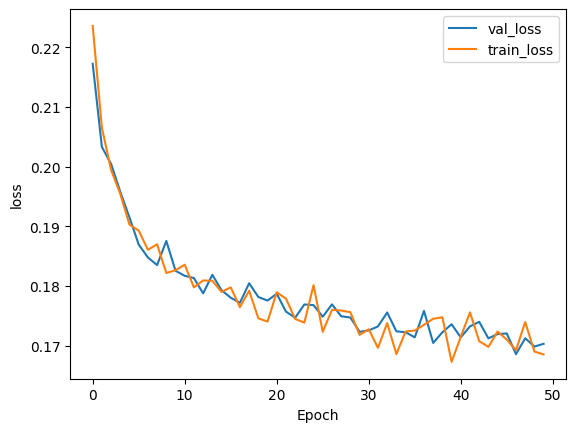

In [18]:
import matplotlib.pyplot as plt

vlosses_values = [t.item() for t in vlosses]
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(range(EPOCHS), vlosses_values, label='val_loss')
plt.plot(range(EPOCHS), tlosses, label='train_loss')
plt.legend()

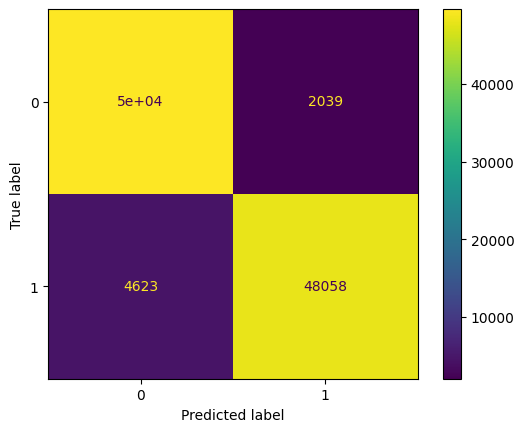

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# model = torch.load('classification_model_auc_083')
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test = y_test.astype(dtype=np.int32)

with torch.no_grad():
    predictions = (model(X_test_tensor).reshape(-1)).cpu().detach().numpy()
    predictions_labels = [1 if p >= 0.5 else 0 for p in predictions]

cm = confusion_matrix(y_test, predictions_labels)
tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [20]:
auc = roc_auc_score(y_test, predictions)

In [21]:
print(auc)

0.9796447045130878


In [60]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

In [61]:
print(fpr, tpr, thresholds)

[0.         0.13299416 0.13299416 ... 0.99843309 0.99990328 1.        ] [0.         0.49091703 0.49093601 ... 1.         1.         1.        ] [          inf 7.7792710e-01 7.7792144e-01 ... 4.3074385e-13 1.3034530e-33
 0.0000000e+00]


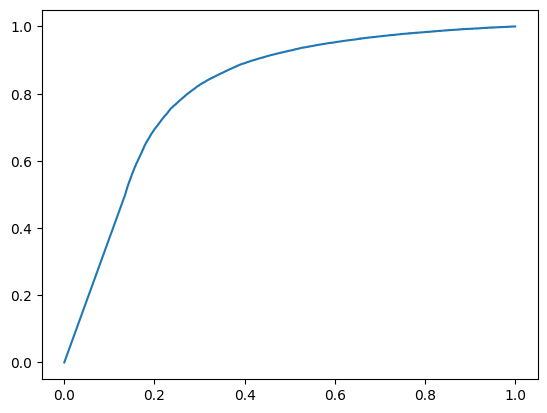

In [62]:
plt.plot(fpr, tpr)

In [22]:
unique, counts = np.unique(y_test, return_counts=True)

print(unique, counts)

[0 1] [51694 52681]


In [61]:
print(model)

SimpleNeuralNet(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (out): Sigmoid()
)
